<a href="https://colab.research.google.com/github/Deepakcode07/LLM_Self_Attention_visualization/blob/main/LLM_Self_Attention_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import io

# Fetch Shakespeare text (public domain)
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
response = requests.get(url)
text = response.text
chars = sorted(list(set(text)))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# Tokenize (simple char-level)
def encode(text): return [char_to_ix[c] for c in text]
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Generate batch for training
def get_batch(split, batch_size=32, block_size=64):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x, y

print(f"Vocab size: {vocab_size}, Train len: {len(train_data)}")

Vocab size: 65, Train len: 1003854


In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd=64, n_head=4, block_size=64):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.attention = nn.MultiheadAttention(n_embd, n_head, batch_first=True)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        b, t = idx.shape
        tok_emb = self.token_embedding(idx)  # (b,t,n_embd)
        pos_emb = self.position_embedding(torch.arange(t, device=idx.device))  # (t,n_embd)
        x = tok_emb + pos_emb  # Residual
        attn_output, attn_weights = self.attention(x, x, x, need_weights=True)  # Self-attn
        logits = self.lm_head(attn_output)

        if targets is None:
            return logits, attn_weights  # Return attention for viz
        else:
            loss = nn.CrossEntropyLoss()(logits.view(-1, vocab_size), targets.view(-1))
            return loss, attn_weights

model = SimpleTransformer(vocab_size)
print(model)

SimpleTransformer(
  (token_embedding): Embedding(65, 64)
  (position_embedding): Embedding(64, 64)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (lm_head): Linear(in_features=64, out_features=65, bias=True)
)


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
batch_size, block_size = 32, 64

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(100)
        for k in range(100):
            X, Y = get_batch(split)
            logits, _ = model(X)
            losses[k] = nn.CrossEntropyLoss()(logits.view(-1, vocab_size), Y.view(-1))
        out[split] = losses.mean()
    model.train()
    return out


for epoch in range(5):
    losses = estimate_loss()
    print(f"Epoch {epoch+1}: Train {losses['train']:.3f}, Val {losses['val']:.3f}")

    for _ in range(100):
        xb, yb = get_batch('train')
        logits, _ = model(xb)
        loss, _ = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def generate(model, idx, max_new_tokens=50):
    model.eval()
    for _ in range(max_new_tokens):
        logits, attn = model(idx[:, -block_size:])
        logits = logits[:, -1, :]
        probs = nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

start = torch.zeros((1, 1), dtype=torch.long)
gen_text = generate(model, start)
print(''.join([ix_to_char[int(i)] for i in gen_text[0]]))

Epoch 1: Train 0.081, Val 0.083
Epoch 2: Train 0.058, Val 0.058
Epoch 3: Train 0.052, Val 0.053
Epoch 4: Train 0.050, Val 0.050
Epoch 5: Train 0.049, Val 0.049






















































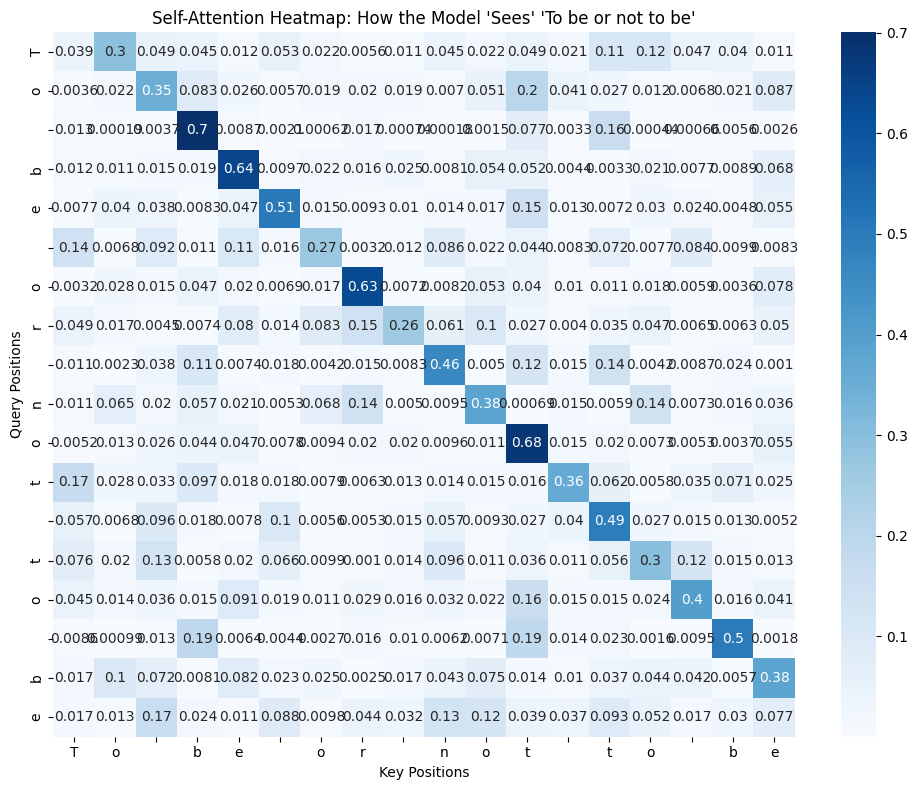

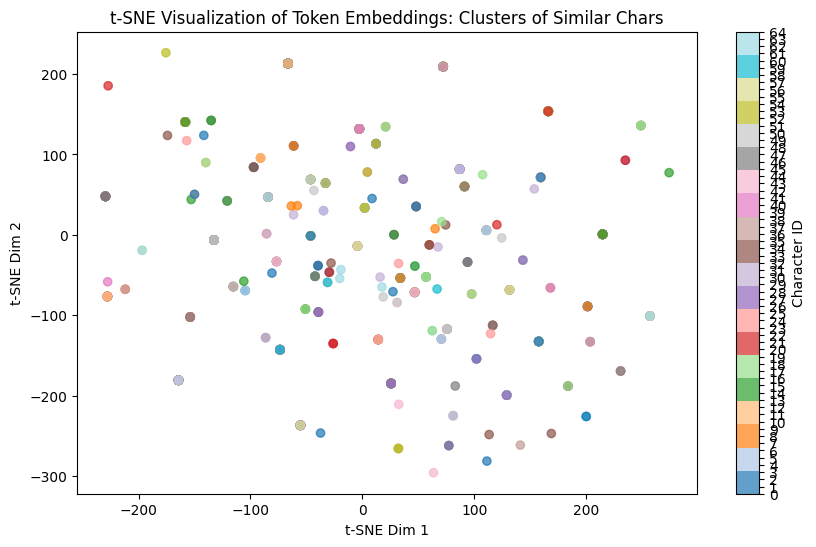

In [ ]:
# Generate with attention capture
context = torch.tensor(encode("To be or not to be")).unsqueeze(0)  # Your query
logits, attention_weights = model(context)  # Get attn weights (b, t, t)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[0].detach().numpy(), annot=True, cmap='Blues',
            xticklabels=[ix_to_char[int(i)] for i in context[0]],
            yticklabels=[ix_to_char[int(i)] for i in context[0]])
plt.title("Self-Attention Heatmap: How the Model 'Sees' 'To be or not to be'")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.tight_layout()
plt.show()

# Bonus: t-SNE Embeddings (project hidden states to 2D)
from sklearn.manifold import TSNE

# Get embeddings for a batch
X, _ = get_batch('train', batch_size=100)
with torch.no_grad():
    emb = model.token_embedding(X.view(-1)).numpy()  # Flatten to tokens

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb[:1000])  # Sample for speed

plt.figure(figsize=(10, 6))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=np.arange(1000)%vocab_size, cmap='tab20', alpha=0.7)
plt.colorbar(scatter, ticks=range(vocab_size), label='Character ID')
plt.title("t-SNE Visualization of Token Embeddings: Clusters of Similar Chars")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()